In [1]:
from src.main import main

models_results_df, all_hyperparams = main('linear_svm', 1)

/home/giovanni/.virtualenvs/news_clf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [2]:
from src.utils import plot_cm

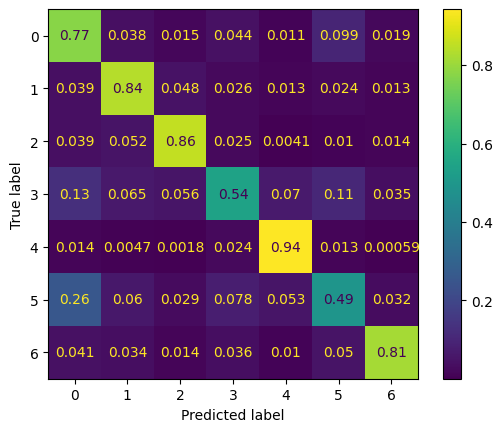

In [7]:
# plot_cm(models_results_df.to_dict()['confusion_matrix'])
plot_cm(models_results_df.to_dict()['confusion_matrix']['linear_svm'])

In [1]:
from src.preprocessing import build_preprocess
from src.utils import load_data
from src.config import *
from src.models import train_model
from src.preprocessing import initial_prep
from sklearn.model_selection import train_test_split
import numpy as np
from src.evaluation import classification_metrics_full
from sklearn.svm import LinearSVC
from src.optimization import optuna_hyp_opt

def refinement(X_train, X_test, y_train, y_test, y_pred, model_name, hyperparams, big):

    mask_train = y_train.isin([0,3,5])
    X_train_g = X_train.loc[mask_train]
    # y_train_g = y_train.loc[mask_train].map({0:0, 3:1, 5:2})
    y_train_g = y_train.loc[mask_train]
    model_name = 'linear_svm'

    best_params = optuna_hyp_opt(model_name, X_train_g, y_train_g, version=1)
    mask_test = np.isin(y_pred, [0,3,5])
    X_test_g = X_test.iloc[mask_test]      
    y_test_g = y_test.iloc[mask_test]


    preprocess = build_preprocess(model_name, big=best_params["big"], include_title=best_params["include_title"], config=best_params["pipeline_params"])
    # preprocess = build_preprocess(model_name, big=best_params["big"], svd=best_params["svd_params"], include_title=best_params["include_title"], config=best_params["pipeline_params"])

    X_train_prep = preprocess.fit_transform(X_train_g)
    X_test_prep = preprocess.transform(X_test_g)

    result, y_pred = train_model(model_name, best_params["model_params"], X_train_prep, X_test_prep, y_train_g, y_test_g)
    # mapping = {0: 0, 1: 3, 2: 5}
    # y_pred = np.vectorize(mapping.get)(y_pred).astype(int)

    return result, y_pred, best_params


def performance2(model_name, hyperparams, big):
    """
    Given a single model name and a dict with the params,
    it returns the performance computed on a single holdout split, only on the DEVELOPMENT dataset.
    """
    news_df = load_data(DEVELOPMENT_PATH)
    X = news_df.drop(columns=['y'])
    y = news_df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    preprocess = build_preprocess(model_name, big=big)
    X_train_prep = preprocess.fit_transform(X_train)
    X_test_prep = preprocess.transform(X_test)
    print(X_train.shape)

    result_old, y_pred = train_model(model_name, hyperparams, X_train_prep, X_test_prep, y_train, y_test)
    res_g, y_pred_g, bp = refinement(X_train, X_test, y_train, y_test, y_pred, model_name, hyperparams, big)
    
    y_pred_old = y_pred.copy()

    y_pred[np.isin(y_pred,[0,3,5])] = y_pred_g

    result = classification_metrics_full(y_test, y_pred)

    return result, result_old, res_g, y_pred, y_test.index, y_pred_old, y_pred_g, bp

/home/giovanni/.virtualenvs/news_clf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

param = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
result, result_old, res_g, y_pred, test_idxs, y_pred_old, y_pred_g, bp = performance2('linear_svm', param, True)

(61302, 17)


Best trial: 43. Best value: 0.674831: 100%|██████████| 100/100 [14:29<00:00,  8.70s/it]


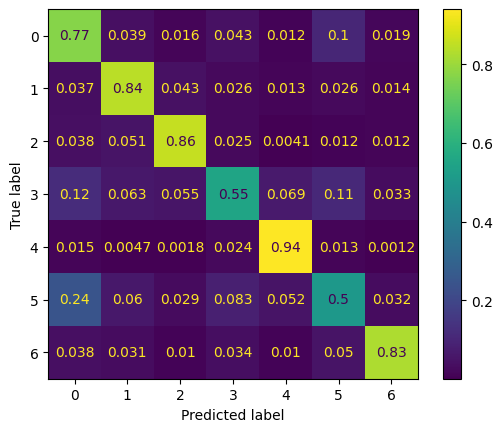

In [3]:
from src.utils import plot_cm
plot_cm(result_old['confusion_matrix'], normalize=True)

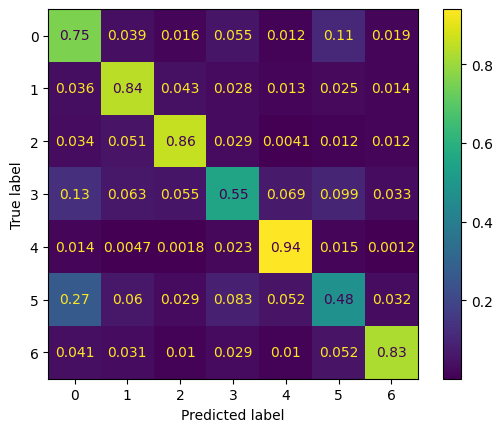

In [4]:
from src.utils import plot_cm
plot_cm(result['confusion_matrix'], normalize=True)

In [3]:

param = {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}
result, result_old, res_g, y_pred, test_idxs, y_pred_old, y_pred_g, bp = performance2('linear_svm', param, True)

(61302, 17)


Best trial: 58. Best value: 0.6876: 100%|██████████| 100/100 [32:40<00:00, 19.60s/it] 


In [6]:
bp

{'model_params': {'C': 0.061288922127393244,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 0.9, 3: 2.8, 5: 1.8},
  'random_state': 1000},
 'pipeline_params': {'article_vec': {'ngram_range': (1, 2),
   'min_df': 3,
   'max_df': 0.8,
   'sublinear_tf': True,
   'norm': 'l2'},
  'title_vec': {'ngram_range': (1, 2),
   'min_df': 2,
   'max_df': 0.8,
   'sublinear_tf': True,
   'norm': 'l2'},
  'article_char_vec': {'ngram_range': (3, 5),
   'min_df': 2,
   'max_df': 0.85,
   'sublinear_tf': True,
   'norm': 'l2'}},
 'include_title': True,
 'big': True}

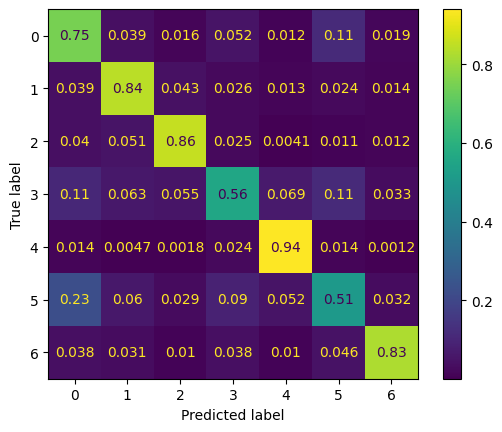

In [7]:
from src.utils import plot_cm
plot_cm(result['confusion_matrix'])

In [5]:
from src.preprocessing import build_preprocess
from src.utils import load_data
from src.config import *
from src.models import train_model
from src.preprocessing import initial_prep
from sklearn.model_selection import train_test_split
import numpy as np
from src.evaluation import classification_metrics_full
from sklearn.svm import LinearSVC
from src.optimization import optuna_hyp_opt

def refinement(X_train, X_test, y_train, y_pred, model_name, hyperparams, big):

    mask_train = y_train.isin([0,3,5])
    X_train_g = X_train.loc[mask_train]
    # y_train_g = y_train.loc[mask_train].map({0:0, 3:1, 5:2})
    y_train_g = y_train.loc[mask_train]
    model_name = 'linear_svm'

    # best_params = optuna_hyp_opt(model_name, X_train_g, y_train_g, version=1)
    best_params = {'model_params': {'C': 0.061288922127393244,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 0.9, 3: 2.8, 5: 1.8},
  'random_state': 1000},
 'pipeline_params': {'article_vec': {'ngram_range': (1, 2),
   'min_df': 3,
   'max_df': 0.8,
   'sublinear_tf': True,
   'norm': 'l2'},
  'title_vec': {'ngram_range': (1, 2),
   'min_df': 2,
   'max_df': 0.8,
   'sublinear_tf': True,
   'norm': 'l2'},
  'article_char_vec': {'ngram_range': (3, 5),
   'min_df': 2,
   'max_df': 0.85,
   'sublinear_tf': True,
   'norm': 'l2'}},
 'include_title': True,
 'big': True}
    
    mask_test = np.isin(y_pred, [0,3,5])
    X_test_g = X_test.iloc[mask_test]      


    preprocess = build_preprocess(model_name, big=best_params["big"], include_title=best_params["include_title"], config=best_params["pipeline_params"])
    # preprocess = build_preprocess(model_name, big=best_params["big"], svd=best_params["svd_params"], include_title=best_params["include_title"], config=best_params["pipeline_params"])

    X_train_prep = preprocess.fit_transform(X_train_g)
    X_test_prep = preprocess.transform(X_test_g)

    y_pred = train_model(model_name, best_params["model_params"], X_train_prep, X_test_prep, y_train_g, y_test=None, submission=
                                 True)

    return y_pred
import pandas as pd
def produce_submissions2(model_name, hyperparams, output_filename, big):
    """
    Given a single model and a parameter grid, it trains the model on the whole DEVELOPMENT dataset
    and produce prediciton for the EVALUATION dataset; it stores these predictions on 'output_filename'. 
    """
    development = load_data(DEVELOPMENT_PATH)
    X_train = development.drop(columns=['y'])
    y_train = development['y']
    X_test = pd.read_csv(EVALUATION_PATH, index_col=0, na_values='\\N')
    X_test = initial_prep(X_test, dev=False)
    idxs = X_test.index

    preprocess = build_preprocess(model_name, big=big)
    X_train_prep = preprocess.fit_transform(X_train)
    X_test_prep = preprocess.transform(X_test)

    y_pred = train_model(model_name, hyperparams, X_train_prep, X_test_prep, y_train, y_test=None, submission=True)

    y_pred_g = refinement(X_train, X_test, y_train, y_pred, model_name, hyperparams, big)
    
    y_pred[np.isin(y_pred,[0,3,5])] = y_pred_g

    submission_df = pd.DataFrame({"Id": idxs, "Predicted": y_pred})

    submission_df.to_csv(SUBMISSION_PATH + '/' + output_filename, index=False)
    print(f'Prediction saved in {output_filename}')

    return submission_df



In [6]:
produce_submissions2('linear_svm', {'C': 0.04773295631615594,
  'max_iter': 5000,
  'dual': True,
  'class_weight': {0: 1.0, 1: 2.2, 2: 2.1, 3: 2.4, 4: 2.7, 5: 1.8, 6: 7.6},
  'random_state': 1000}, big=True, output_filename='v24_my_two_stage.csv')

Prediction saved in v24_my_two_stage.csv


,Id,Predicted
0,0,5
1,1,2
2,2,5
3,3,0
4,4,0
...,...,...
19995,19995,2
19996,19996,4
19997,19997,3
19998,19998,0
